# Flow Data Quality Control Analysis

This notebook performs quality control analysis on MA350 flow measurement data from two locations: Jacros and Pasadena.

## Key Metrics:
- **R** = Flow1 / Flow2 (target: 3.0)
- **f1** = Flow1 / Flow_total (target: 0.75)
- **f2** = Flow2 / Flow_total (target: 0.25)
- **S** = (Flow1 + Flow2) / Flow_total (target: 1.00)
- **T** = Flow_total / Flow_setpoint (target: 1.00)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Figure settings
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

## 1. Load and Prepare Data

In [2]:
# Load data from both locations
jacros_df = pd.read_csv('/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Raw/Jacros_MA350_1-min_2022-2024_Cleaned.csv')
pasadena_df = pd.read_csv('/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Raw/Pasadena_MA350_1-min_2023-2024_Cleaned.csv')

# Add location identifier
jacros_df['Location'] = 'Jacros'
pasadena_df['Location'] = 'Pasadena'

print(f"Jacros data: {len(jacros_df)} records")
print(f"Pasadena data: {len(pasadena_df)} records")
print("\nColumn names:")
print(jacros_df.columns.tolist()[:30])  # Show first 30 columns

Jacros data: 1095086 records
Pasadena data: 471232 records

Column names:
['Serial number', 'Time (UTC)', 'Datum ID', 'Session ID', 'Data format version', 'Firmware version', 'App version', 'Timezone offset (mins)', 'Date local (yyyy/MM/dd)', 'Time local (hh:mm:ss)', 'GPS lat (ddmm.mmmmm)', 'GPS long (dddmm.mmmmm)', 'GPS speed (km/h)', 'GPS sat count', 'Timebase (s)', 'Status', 'Battery remaining (%)', 'Accel X', 'Accel Y', 'Accel Z', 'Tape position', 'Flow setpoint (mL/min)', 'Flow total (mL/min)', 'Flow1 (mL/min)', 'Flow2 (mL/min)', 'Sample temp (C)', 'Sample RH (%)', 'Sample dewpoint (C)', 'Internal pressure (Pa)', 'Internal temp (C)']


In [3]:
# Function to process each dataset
def process_flow_data(df, location_name):
    """
    Process flow data and compute QC metrics
    """
    # Create a copy to avoid modifying original
    df_proc = df.copy()
    
    # Parse datetime
    df_proc['Timestamp'] = pd.to_datetime(df_proc['Time (UTC)'])
    
    # Extract flow columns - ensure proper naming
    df_proc['Flow_setpoint'] = pd.to_numeric(df_proc['Flow setpoint (mL/min)'], errors='coerce')
    df_proc['Flow_total'] = pd.to_numeric(df_proc['Flow total (mL/min)'], errors='coerce')
    df_proc['Flow1'] = pd.to_numeric(df_proc['Flow1 (mL/min)'], errors='coerce')
    df_proc['Flow2'] = pd.to_numeric(df_proc['Flow2 (mL/min)'], errors='coerce')
    
    # Remove rows with missing flow data
    df_proc = df_proc.dropna(subset=['Flow_setpoint', 'Flow_total', 'Flow1', 'Flow2'])
    
    # Compute metrics with safe division
    with np.errstate(divide='ignore', invalid='ignore'):
        # R = Flow1 / Flow2 (target 3.0)
        df_proc['R'] = df_proc['Flow1'] / df_proc['Flow2']
        df_proc['R'] = df_proc['R'].replace([np.inf, -np.inf], np.nan)
        
        # f1 = Flow1 / Flow_total (target 0.75)
        df_proc['f1'] = df_proc['Flow1'] / df_proc['Flow_total']
        df_proc['f1'] = df_proc['f1'].replace([np.inf, -np.inf], np.nan)
        
        # f2 = Flow2 / Flow_total (target 0.25)
        df_proc['f2'] = df_proc['Flow2'] / df_proc['Flow_total']
        df_proc['f2'] = df_proc['f2'].replace([np.inf, -np.inf], np.nan)
        
        # S = (Flow1 + Flow2) / Flow_total (target 1.00)
        df_proc['S'] = (df_proc['Flow1'] + df_proc['Flow2']) / df_proc['Flow_total']
        df_proc['S'] = df_proc['S'].replace([np.inf, -np.inf], np.nan)
        
        # T = Flow_total / Flow_setpoint (target 1.00)
        df_proc['T'] = df_proc['Flow_total'] / df_proc['Flow_setpoint']
        df_proc['T'] = df_proc['T'].replace([np.inf, -np.inf], np.nan)
    
    # Note: Actual R values appear to be around 1.2-2.5, not 3.0
    # Let's calculate actual median to use as reference
    actual_R_target = df_proc['R'].median()
    
    # Adjust QC Flags based on actual data distribution
    # Using relative bands around actual median
    df_proc['R_deviation'] = np.abs(df_proc['R'] - actual_R_target)
    df_proc['flag_R_pass'] = df_proc['R_deviation'] <= (actual_R_target * 0.05)  # ±5%
    df_proc['flag_R_warn'] = (df_proc['R_deviation'] > (actual_R_target * 0.05)) & \
                             (df_proc['R_deviation'] <= (actual_R_target * 0.10))  # ±10%
    df_proc['flag_R_fail'] = df_proc['R_deviation'] > (actual_R_target * 0.10)
    
    # Sum and Setpoint flags
    df_proc['flag_S'] = np.abs(df_proc['S'] - 1.00) <= 0.02
    df_proc['flag_T'] = np.abs(df_proc['T'] - 1.00) <= 0.02
    
    # Combined flag
    df_proc['QC_pass'] = df_proc['flag_R_pass'] & df_proc['flag_S'] & df_proc['flag_T']
    
    # Calculate additional diagnostics
    df_proc['Flow_sum_diff'] = (df_proc['Flow1'] + df_proc['Flow2']) - df_proc['Flow_total']
    df_proc['Flow_setpoint_diff'] = df_proc['Flow_total'] - df_proc['Flow_setpoint']
    
    print(f"\n{location_name} - Data processed:")
    print(f"  Total records: {len(df_proc)}")
    print(f"  Date range: {df_proc['Timestamp'].min()} to {df_proc['Timestamp'].max()}")
    print(f"  R median (actual): {df_proc['R'].median():.3f}")
    print(f"  R mean: {df_proc['R'].mean():.3f}")
    print(f"  R std: {df_proc['R'].std():.3f}")
    print(f"  QC Pass rate: {df_proc['QC_pass'].mean()*100:.1f}%")
    
    # Store the actual target for later use
    df_proc.attrs['R_target'] = actual_R_target
    
    return df_proc

# Process both datasets
jacros_processed = process_flow_data(jacros_df, 'Jacros')
pasadena_processed = process_flow_data(pasadena_df, 'Pasadena')

# Create hourly averaged versions for better visualization
def create_hourly_average(df, location_name):
    """
    Create hourly averages for smoother time series plots
    """
    df_hourly = df.set_index('Timestamp').resample('1H').agg({
        'R': 'median',
        'f1': 'median',
        'f2': 'median',
        'S': 'median',
        'T': 'median',
        'Flow1': 'mean',
        'Flow2': 'mean',
        'Flow_total': 'mean',
        'Flow_setpoint': 'mean',
        'Flow_sum_diff': 'mean',
        'Flow_setpoint_diff': 'mean',
        'flag_R_pass': 'mean',  # Fraction passing in that hour
        'flag_R_warn': 'mean',
        'flag_R_fail': 'mean',
        'QC_pass': 'mean'
    }).dropna()
    
    df_hourly = df_hourly.reset_index()
    df_hourly['Location'] = location_name
    df_hourly.attrs['R_target'] = df.attrs['R_target']
    
    print(f"\n{location_name} - Hourly averages created:")
    print(f"  Total hours with data: {len(df_hourly)}")
    
    return df_hourly

jacros_hourly = create_hourly_average(jacros_processed, 'Jacros')
pasadena_hourly = create_hourly_average(pasadena_processed, 'Pasadena')


Jacros - Data processed:
  Total records: 1095086
  Date range: 2022-04-12 09:46:01+00:00 to 2024-08-20 09:01:00+00:00
  R median (actual): 1.206
  R mean: 1.210
  R std: 0.077
  QC Pass rate: 57.5%

Pasadena - Data processed:
  Total records: 471232
  Date range: 2023-06-23 15:46:59+00:00 to 2024-05-31 01:48:59+00:00
  R median (actual): 2.467
  R mean: 2.480
  R std: 0.160
  QC Pass rate: 58.0%

Jacros - Hourly averages created:
  Total hours with data: 18326

Pasadena - Hourly averages created:
  Total hours with data: 7863


## 2. Summary Statistics

In [4]:
def print_summary_stats(df, location):
    """
    Print detailed summary statistics for QC metrics
    """
    print(f"\n{'='*60}")
    print(f"SUMMARY STATISTICS - {location}")
    print(f"{'='*60}")
    
    metrics = ['R', 'f1', 'f2', 'S', 'T']
    targets = [3.0, 0.75, 0.25, 1.00, 1.00]
    
    for metric, target in zip(metrics, targets):
        if metric in df.columns:
            values = df[metric].dropna()
            print(f"\n{metric} (target: {target})")
            print(f"  Mean:   {values.mean():.4f}")
            print(f"  Median: {values.median():.4f}")
            print(f"  Std:    {values.std():.4f}")
            print(f"  5th:    {values.quantile(0.05):.4f}")
            print(f"  95th:   {values.quantile(0.95):.4f}")
            print(f"  IQR:    {values.quantile(0.75) - values.quantile(0.25):.4f}")
    
    # QC Flag statistics
    print(f"\n{'QC FLAGS':^20}")
    print(f"  R Pass:  {df['flag_R_pass'].sum()} ({df['flag_R_pass'].mean()*100:.1f}%)")
    print(f"  R Warn:  {df['flag_R_warn'].sum()} ({df['flag_R_warn'].mean()*100:.1f}%)")
    print(f"  R Fail:  {df['flag_R_fail'].sum()} ({df['flag_R_fail'].mean()*100:.1f}%)")
    print(f"  S Pass:  {df['flag_S'].sum()} ({df['flag_S'].mean()*100:.1f}%)")
    print(f"  T Pass:  {df['flag_T'].sum()} ({df['flag_T'].mean()*100:.1f}%)")
    print(f"  Overall: {df['QC_pass'].sum()} ({df['QC_pass'].mean()*100:.1f}%)")

# Print summary for both locations
print_summary_stats(jacros_processed, 'Jacros')
print_summary_stats(pasadena_processed, 'Pasadena')


SUMMARY STATISTICS - Jacros

R (target: 3.0)
  Mean:   1.2103
  Median: 1.2060
  Std:    0.0769
  5th:    1.0905
  95th:   1.3447
  IQR:    0.1016

f1 (target: 0.75)
  Mean:   0.5470
  Median: 0.5467
  Std:    0.0156
  5th:    0.5216
  95th:   0.5735
  IQR:    0.0209

f2 (target: 0.25)
  Mean:   0.4530
  Median: 0.4533
  Std:    0.0156
  5th:    0.4265
  95th:   0.4784
  IQR:    0.0209

S (target: 1.0)
  Mean:   1.0000
  Median: 1.0000
  Std:    0.0000
  5th:    0.9999
  95th:   1.0001
  IQR:    0.0000

T (target: 1.0)
  Mean:   1.0000
  Median: 1.0000
  Std:    0.0031
  5th:    0.9955
  95th:   1.0045
  IQR:    0.0042

      QC FLAGS      
  R Pass:  630646 (57.6%)
  R Warn:  337496 (30.8%)
  R Fail:  126944 (11.6%)
  S Pass:  1095086 (100.0%)
  T Pass:  1093784 (99.9%)
  Overall: 630195 (57.5%)

SUMMARY STATISTICS - Pasadena

R (target: 3.0)
  Mean:   2.4798
  Median: 2.4670
  Std:    0.1600
  5th:    2.2190
  95th:   2.7777
  IQR:    0.2008

f1 (target: 0.75)
  Mean:   0.7120
  Med

## 3. Time Series Diagnostics

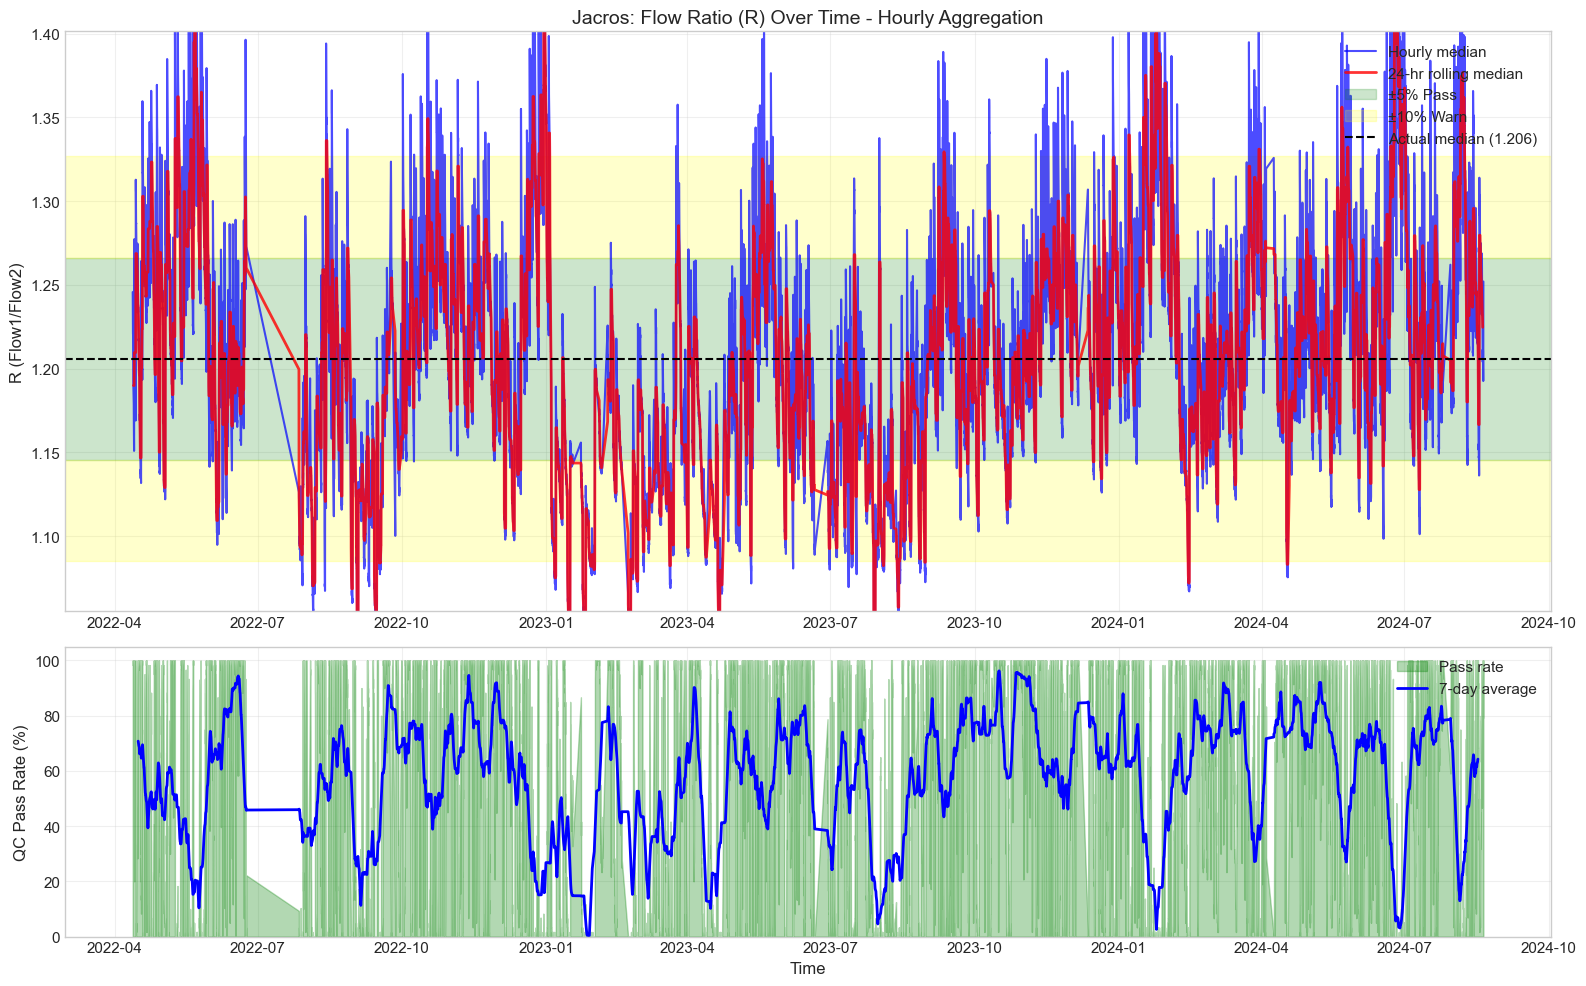

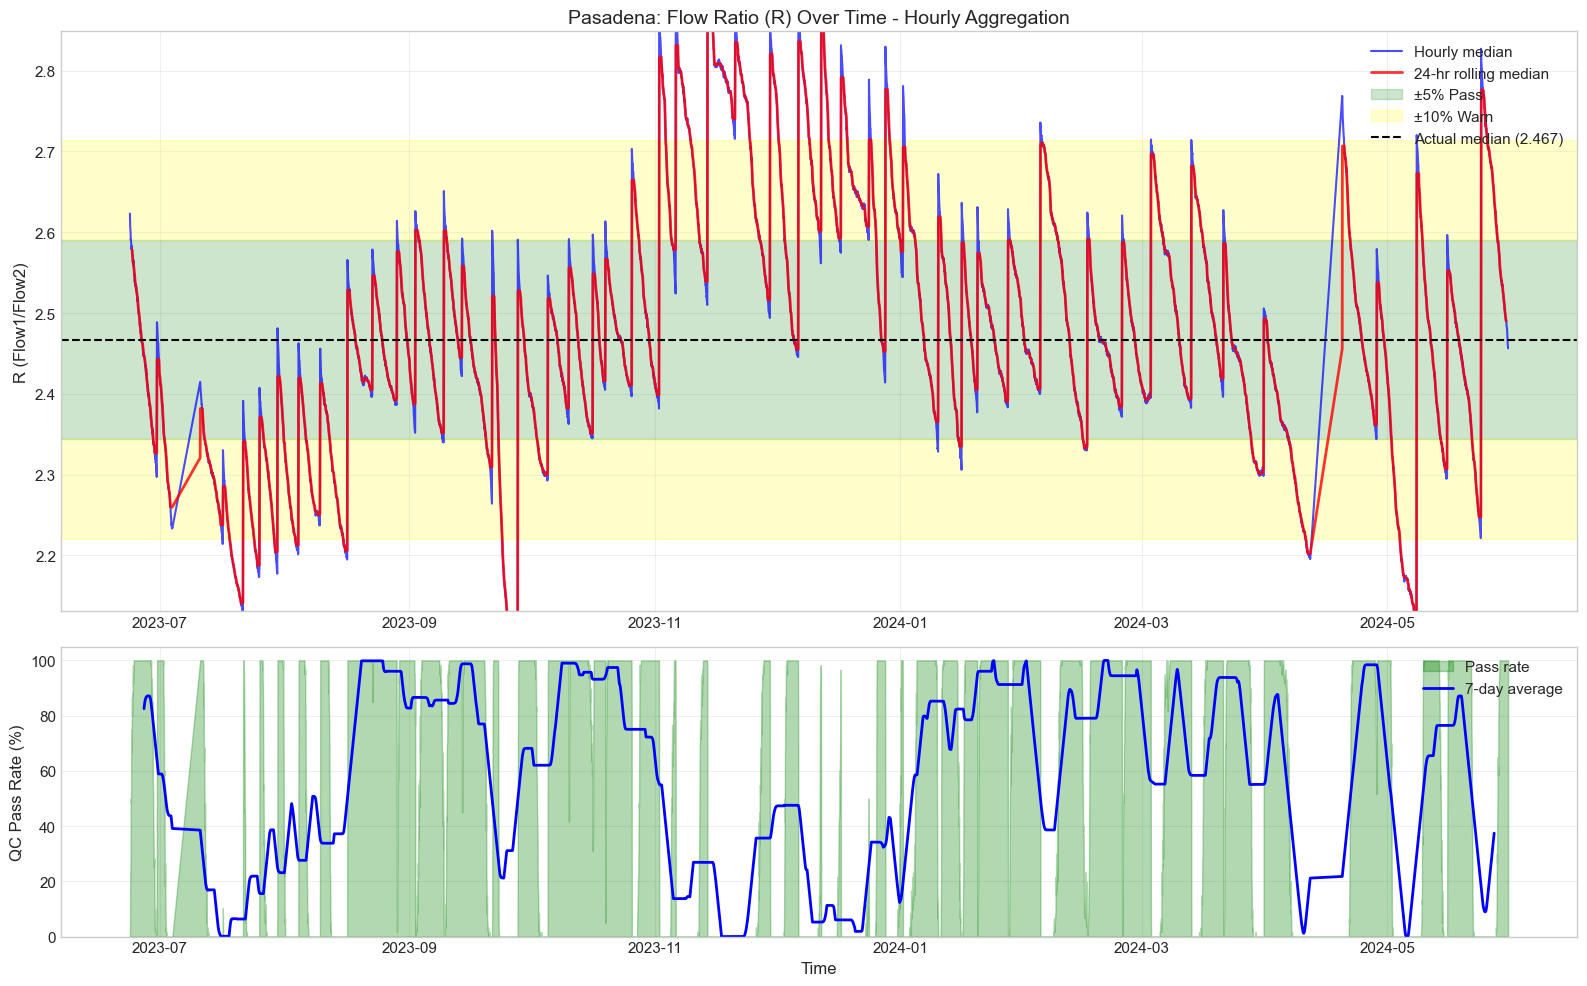

In [5]:
def plot_ratio_timeseries_improved(df_minute, df_hourly, location):
    """
    Improved Plot 1: R over time with QC bands
    Shows both hourly trend and individual points
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), 
                                   gridspec_kw={'height_ratios': [2, 1]})
    
    # Get actual R target from data
    R_target = df_minute.attrs['R_target']
    
    # Top plot: Hourly data with connected lines
    ax1.plot(df_hourly['Timestamp'], df_hourly['R'], 
            'b-', linewidth=1.5, alpha=0.7, label='Hourly median')
    
    # Add rolling average for smoother trend
    if len(df_hourly) > 24:
        rolling_R = df_hourly['R'].rolling(window=24, center=True).median()
        ax1.plot(df_hourly['Timestamp'], rolling_R, 
                'r-', linewidth=2, alpha=0.8, label='24-hr rolling median')
    
    # Add QC bands based on actual target
    ax1.axhspan(R_target * 0.95, R_target * 1.05, 
               alpha=0.2, color='green', label='±5% Pass')
    ax1.axhspan(R_target * 0.90, R_target * 0.95, 
               alpha=0.2, color='yellow', label='±10% Warn')
    ax1.axhspan(R_target * 1.05, R_target * 1.10, 
               alpha=0.2, color='yellow')
    
    # Target line
    ax1.axhline(y=R_target, color='black', linestyle='--', 
               linewidth=1.5, label=f'Actual median ({R_target:.3f})')
    
    # Set reasonable y-limits based on actual data
    y_min = max(df_hourly['R'].quantile(0.01), R_target * 0.8)
    y_max = min(df_hourly['R'].quantile(0.99), R_target * 1.2)
    ax1.set_ylim(y_min, y_max)
    
    ax1.set_ylabel('R (Flow1/Flow2)')
    ax1.set_title(f'{location}: Flow Ratio (R) Over Time - Hourly Aggregation')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Bottom plot: QC pass rate over time
    ax2.fill_between(df_hourly['Timestamp'], 
                    df_hourly['flag_R_pass'] * 100,
                    alpha=0.3, color='green', label='Pass rate')
    ax2.plot(df_hourly['Timestamp'], 
            df_hourly['flag_R_pass'].rolling(window=24*7, center=True).mean() * 100,
            'b-', linewidth=2, label='7-day average')
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('QC Pass Rate (%)')
    ax2.set_ylim(0, 105)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create improved ratio plots
fig1 = plot_ratio_timeseries_improved(jacros_processed, jacros_hourly, 'Jacros')
plt.show()

fig2 = plot_ratio_timeseries_improved(pasadena_processed, pasadena_hourly, 'Pasadena')
plt.show()

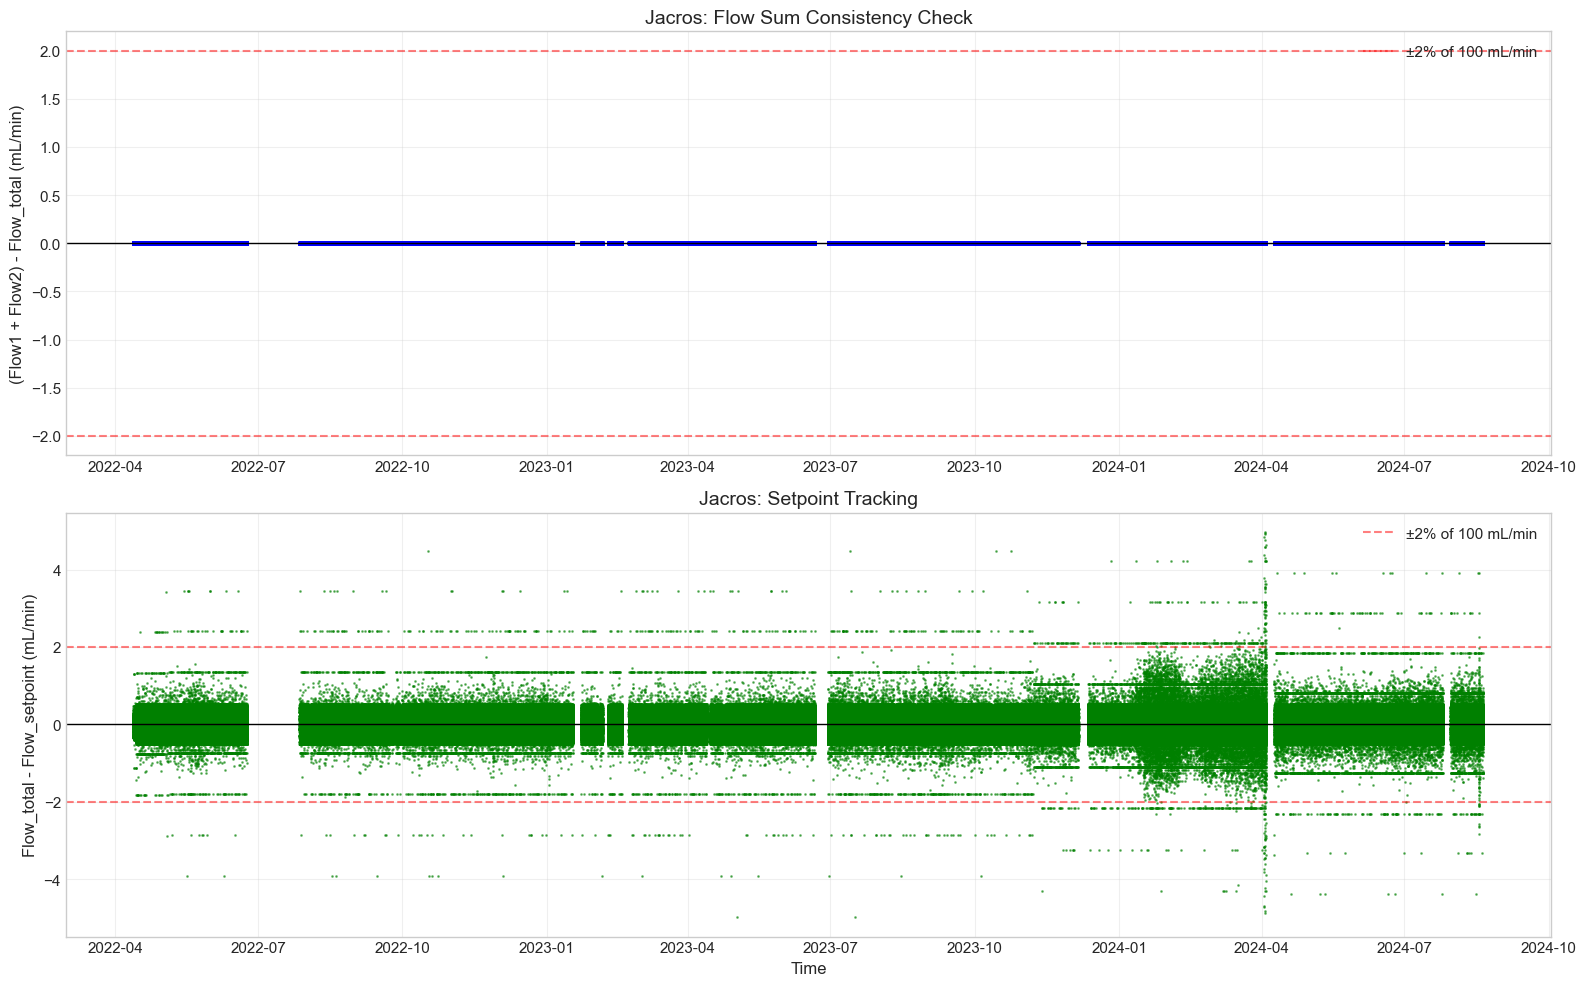

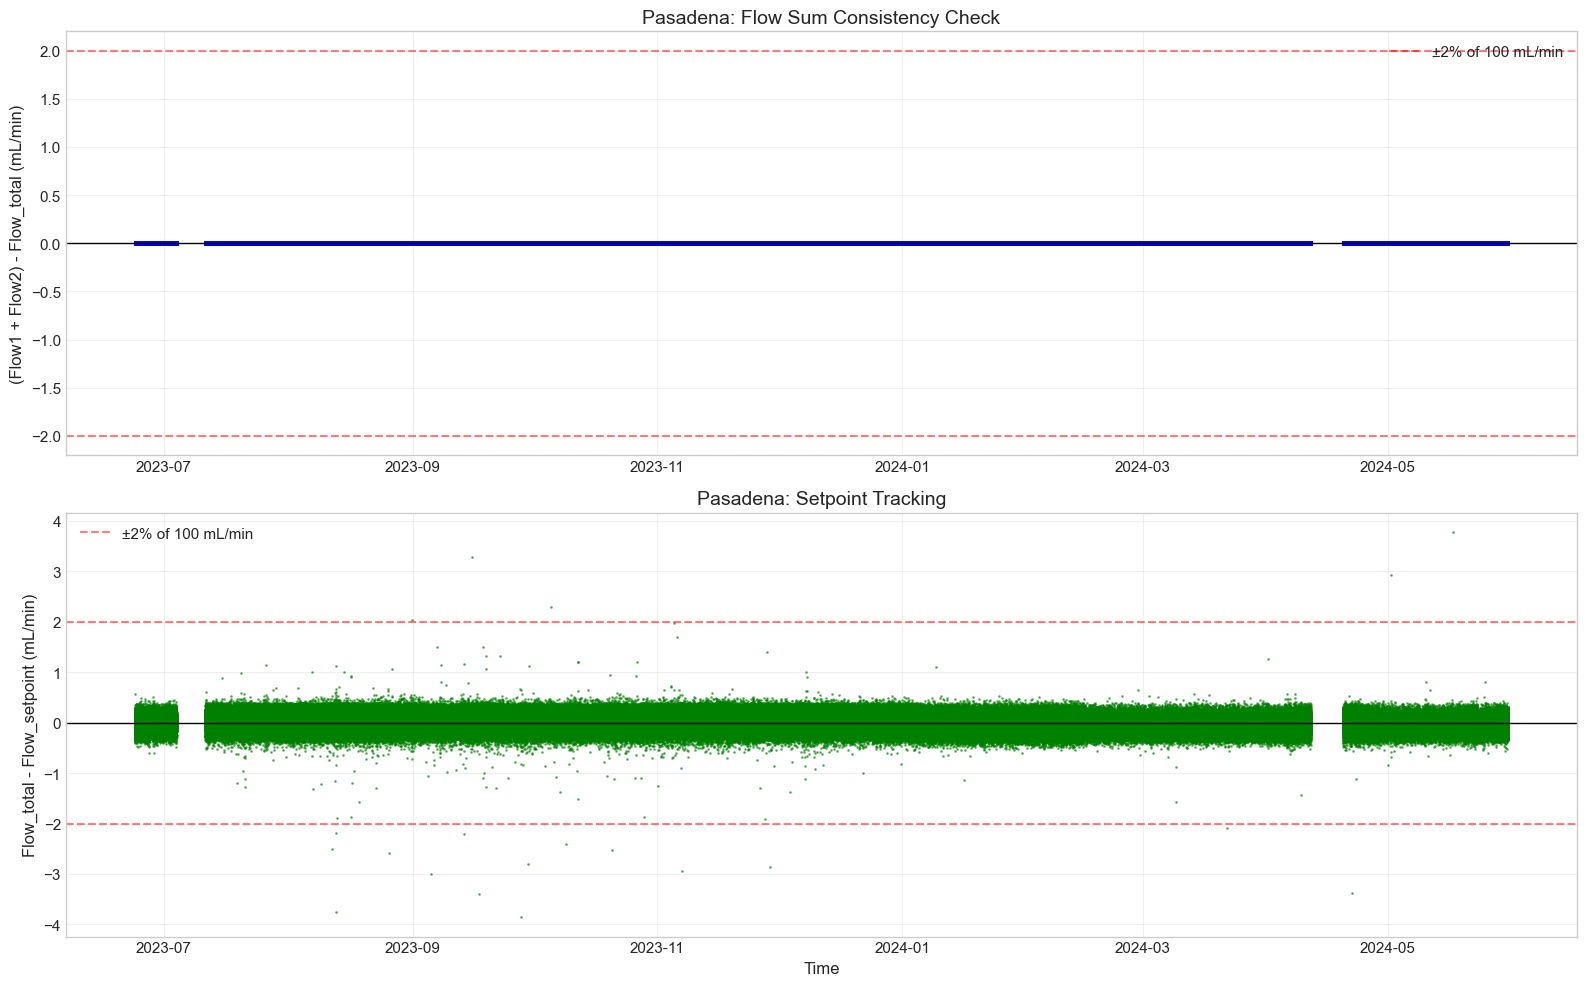

In [6]:
def plot_flow_differences(df, location):
    """
    Plot 2: Flow sum difference and setpoint difference over time
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    
    # Plot (Flow1 + Flow2) - Flow_total
    ax1.scatter(df['Timestamp'], df['Flow_sum_diff'], alpha=0.5, s=1, c='blue')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax1.axhline(y=2, color='red', linestyle='--', alpha=0.5, label='±2% of 100 mL/min')
    ax1.axhline(y=-2, color='red', linestyle='--', alpha=0.5)
    ax1.set_ylabel('(Flow1 + Flow2) - Flow_total (mL/min)')
    ax1.set_title(f'{location}: Flow Sum Consistency Check')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot Flow_total - Flow_setpoint
    ax2.scatter(df['Timestamp'], df['Flow_setpoint_diff'], alpha=0.5, s=1, c='green')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.axhline(y=2, color='red', linestyle='--', alpha=0.5, label='±2% of 100 mL/min')
    ax2.axhline(y=-2, color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Flow_total - Flow_setpoint (mL/min)')
    ax2.set_title(f'{location}: Setpoint Tracking')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Create flow difference plots
fig3 = plot_flow_differences(jacros_processed, 'Jacros')
plt.show()

fig4 = plot_flow_differences(pasadena_processed, 'Pasadena')
plt.show()

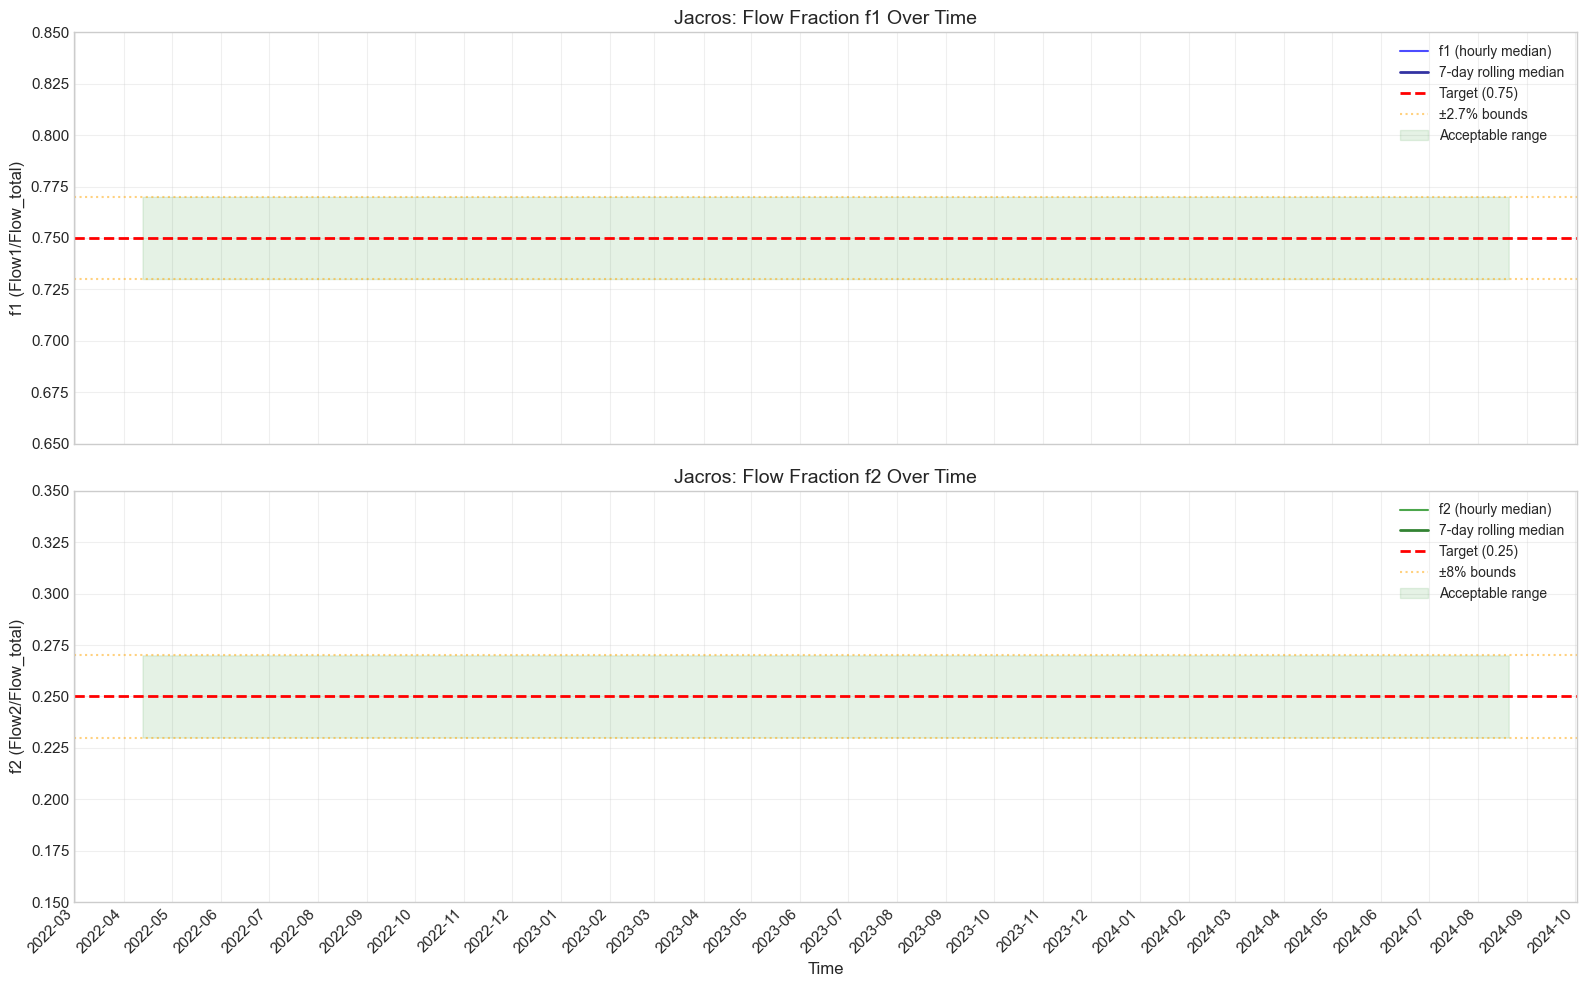

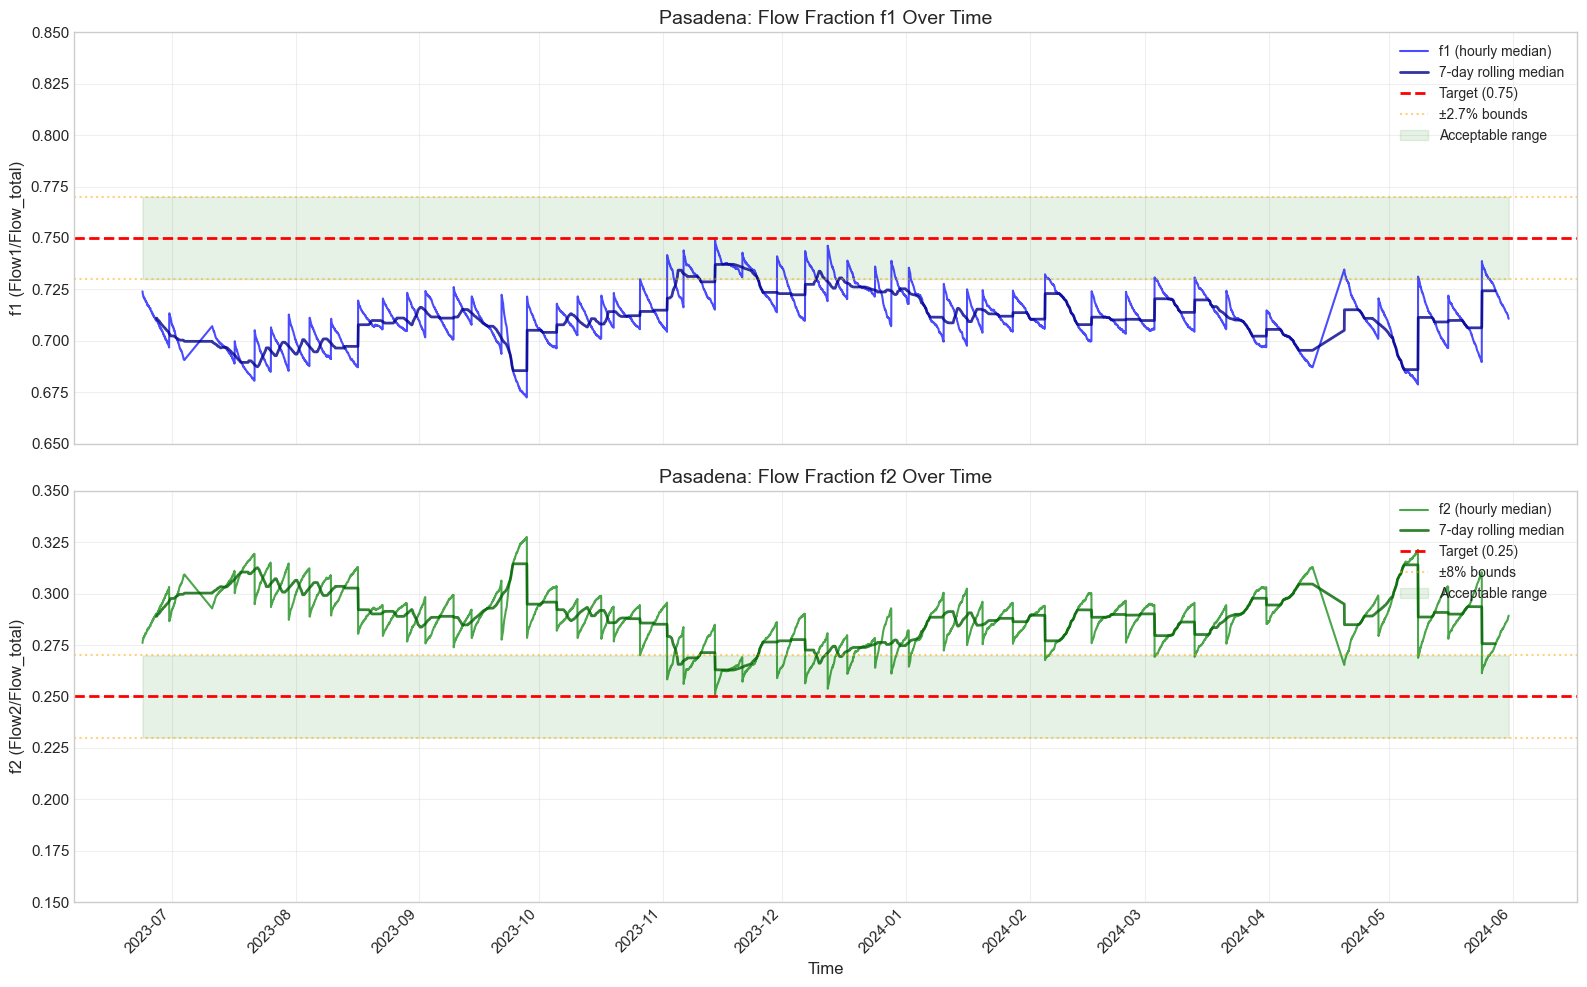

In [7]:
def plot_flow_fractions_improved(df_hourly, location):
    """
    Improved Plot 3: Fractions f1 and f2 over time using hourly data
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # Plot f1 (Flow1/Flow_total) - connected line for hourly data
    ax1.plot(df_hourly['Timestamp'], df_hourly['f1'], 
            'b-', linewidth=1.5, alpha=0.7, label='f1 (hourly median)')
    
    # Add rolling average
    if len(df_hourly) > 24:
        f1_rolling = df_hourly['f1'].rolling(window=24*7, center=True).median()
        ax1.plot(df_hourly['Timestamp'], f1_rolling, 
                'darkblue', linewidth=2, alpha=0.8, label='7-day rolling median')
    
    ax1.axhline(y=0.75, color='red', linestyle='--', linewidth=2, label='Target (0.75)')
    ax1.axhline(y=0.73, color='orange', linestyle=':', alpha=0.5, label='±2.7% bounds')
    ax1.axhline(y=0.77, color='orange', linestyle=':', alpha=0.5)
    
    # Fill area between bounds
    ax1.fill_between(df_hourly['Timestamp'], 0.73, 0.77, 
                    alpha=0.1, color='green', label='Acceptable range')
    
    ax1.set_ylabel('f1 (Flow1/Flow_total)', fontsize=12)
    ax1.set_ylim(0.65, 0.85)
    ax1.set_title(f'{location}: Flow Fraction f1 Over Time', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=10)
    
    # Plot f2 (Flow2/Flow_total) - connected line for hourly data
    ax2.plot(df_hourly['Timestamp'], df_hourly['f2'], 
            'g-', linewidth=1.5, alpha=0.7, label='f2 (hourly median)')
    
    # Add rolling average
    if len(df_hourly) > 24:
        f2_rolling = df_hourly['f2'].rolling(window=24*7, center=True).median()
        ax2.plot(df_hourly['Timestamp'], f2_rolling, 
                'darkgreen', linewidth=2, alpha=0.8, label='7-day rolling median')
    
    ax2.axhline(y=0.25, color='red', linestyle='--', linewidth=2, label='Target (0.25)')
    ax2.axhline(y=0.23, color='orange', linestyle=':', alpha=0.5, label='±8% bounds')
    ax2.axhline(y=0.27, color='orange', linestyle=':', alpha=0.5)
    
    # Fill area between bounds
    ax2.fill_between(df_hourly['Timestamp'], 0.23, 0.27, 
                    alpha=0.1, color='green', label='Acceptable range')
    
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('f2 (Flow2/Flow_total)', fontsize=12)
    ax2.set_ylim(0.15, 0.35)
    ax2.set_title(f'{location}: Flow Fraction f2 Over Time', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right', fontsize=10)
    
    # Format x-axis
    from matplotlib.dates import DateFormatter, MonthLocator
    if (df_hourly['Timestamp'].max() - df_hourly['Timestamp'].min()).days > 90:
        ax2.xaxis.set_major_locator(MonthLocator())
        ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    return fig

# Create improved fraction plots
fig5 = plot_flow_fractions_improved(jacros_hourly, 'Jacros')
plt.show()

fig6 = plot_flow_fractions_improved(pasadena_hourly, 'Pasadena')
plt.show()

## 4. Statistical Distributions

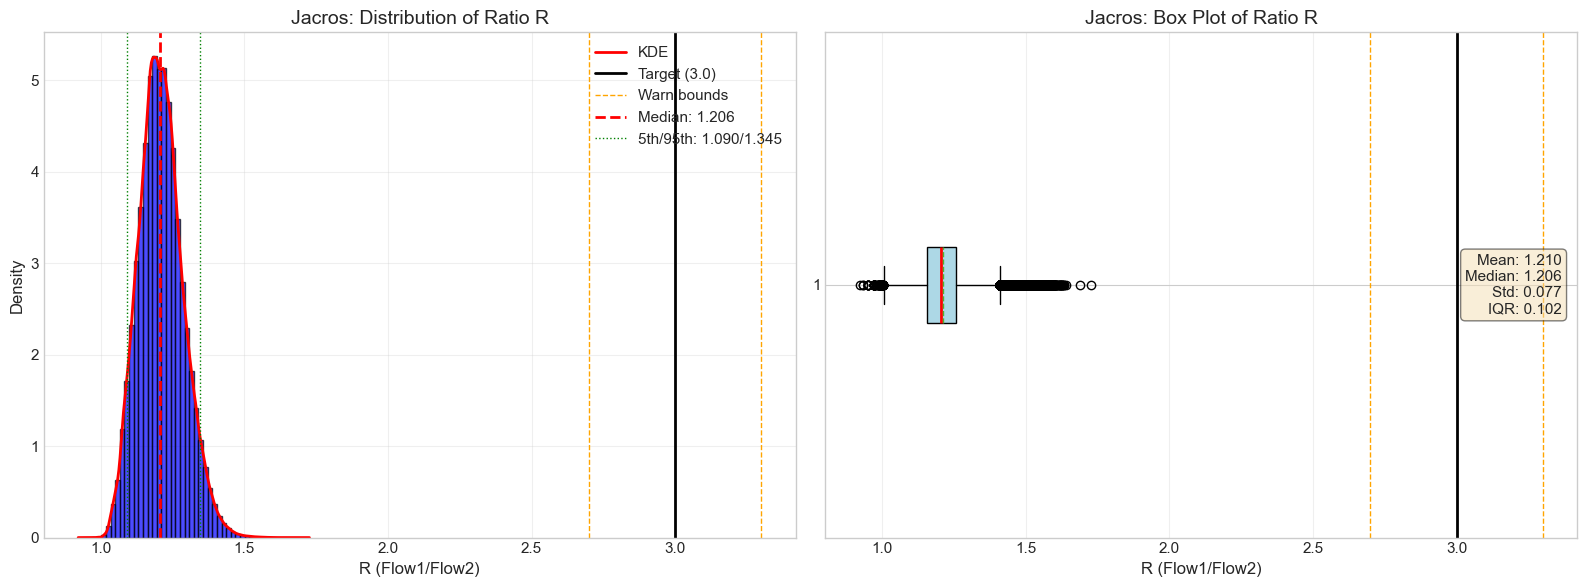

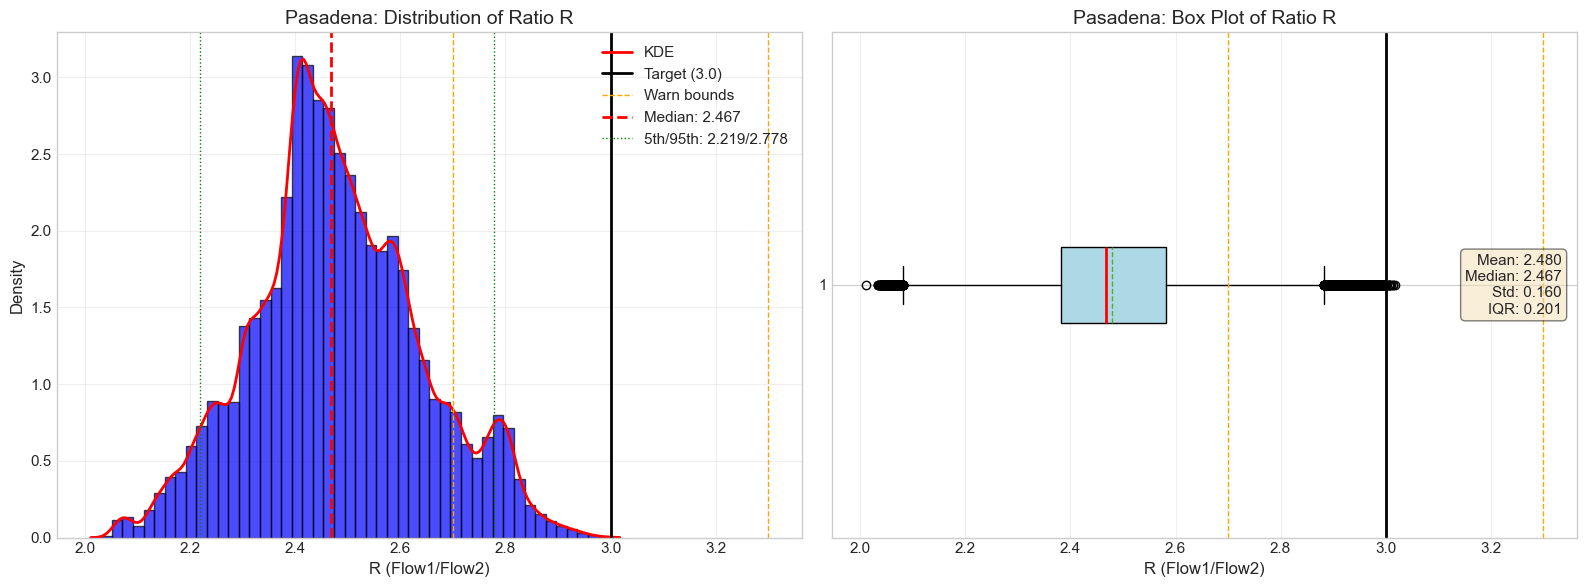

In [8]:
def plot_ratio_distribution(df, location):
    """
    Plot 4: Histogram/KDE of R with percentile markers
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    R_clean = df['R'].dropna()
    
    # Histogram
    ax1.hist(R_clean, bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
    
    # KDE overlay
    from scipy import stats
    kde = stats.gaussian_kde(R_clean)
    x_range = np.linspace(R_clean.min(), R_clean.max(), 200)
    ax1.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    # Add reference lines
    ax1.axvline(x=3.0, color='black', linestyle='-', linewidth=2, label='Target (3.0)')
    ax1.axvline(x=2.7, color='orange', linestyle='--', linewidth=1, label='Warn bounds')
    ax1.axvline(x=3.3, color='orange', linestyle='--', linewidth=1)
    
    # Add percentile markers
    median = R_clean.median()
    p5 = R_clean.quantile(0.05)
    p95 = R_clean.quantile(0.95)
    
    ax1.axvline(x=median, color='red', linestyle='--', linewidth=2, 
               label=f'Median: {median:.3f}')
    ax1.axvline(x=p5, color='green', linestyle=':', linewidth=1, 
               label=f'5th/95th: {p5:.3f}/{p95:.3f}')
    ax1.axvline(x=p95, color='green', linestyle=':', linewidth=1)
    
    ax1.set_xlabel('R (Flow1/Flow2)')
    ax1.set_ylabel('Density')
    ax1.set_title(f'{location}: Distribution of Ratio R')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    bp = ax2.boxplot([R_clean], vert=False, patch_artist=True, 
                     showmeans=True, meanline=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['medians'][0].set(color='red', linewidth=2)
    
    ax2.axvline(x=3.0, color='black', linestyle='-', linewidth=2)
    ax2.axvline(x=2.7, color='orange', linestyle='--', linewidth=1)
    ax2.axvline(x=3.3, color='orange', linestyle='--', linewidth=1)
    
    # Annotate statistics
    stats_text = f"Mean: {R_clean.mean():.3f}\n"
    stats_text += f"Median: {median:.3f}\n"
    stats_text += f"Std: {R_clean.std():.3f}\n"
    stats_text += f"IQR: {R_clean.quantile(0.75) - R_clean.quantile(0.25):.3f}"
    
    ax2.text(0.98, 0.5, stats_text, transform=ax2.transAxes, 
            fontsize=11, verticalalignment='center',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax2.set_xlabel('R (Flow1/Flow2)')
    ax2.set_title(f'{location}: Box Plot of Ratio R')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig

# Create distribution plots
fig7 = plot_ratio_distribution(jacros_processed, 'Jacros')
plt.show()

fig8 = plot_ratio_distribution(pasadena_processed, 'Pasadena')
plt.show()

## 5. Flow1 vs Flow2 Scatter Analysis

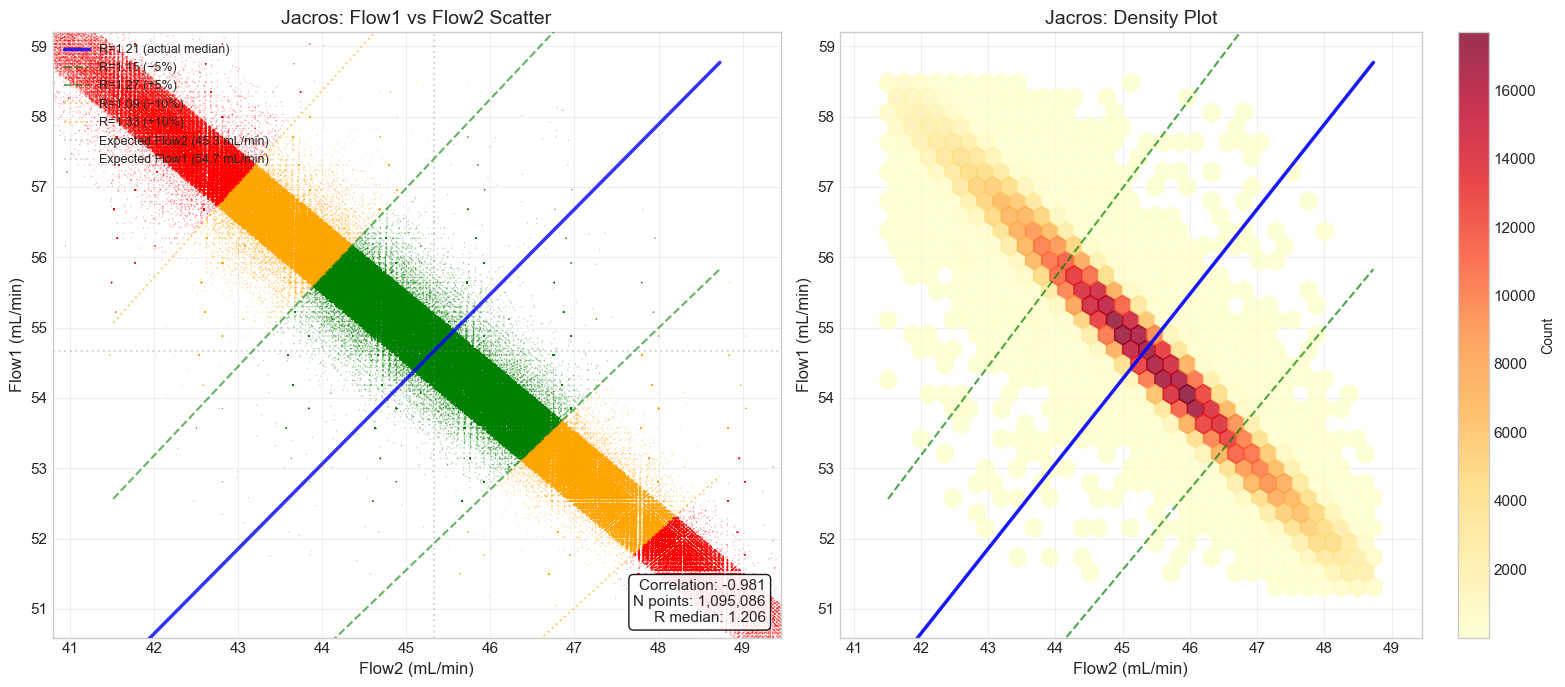

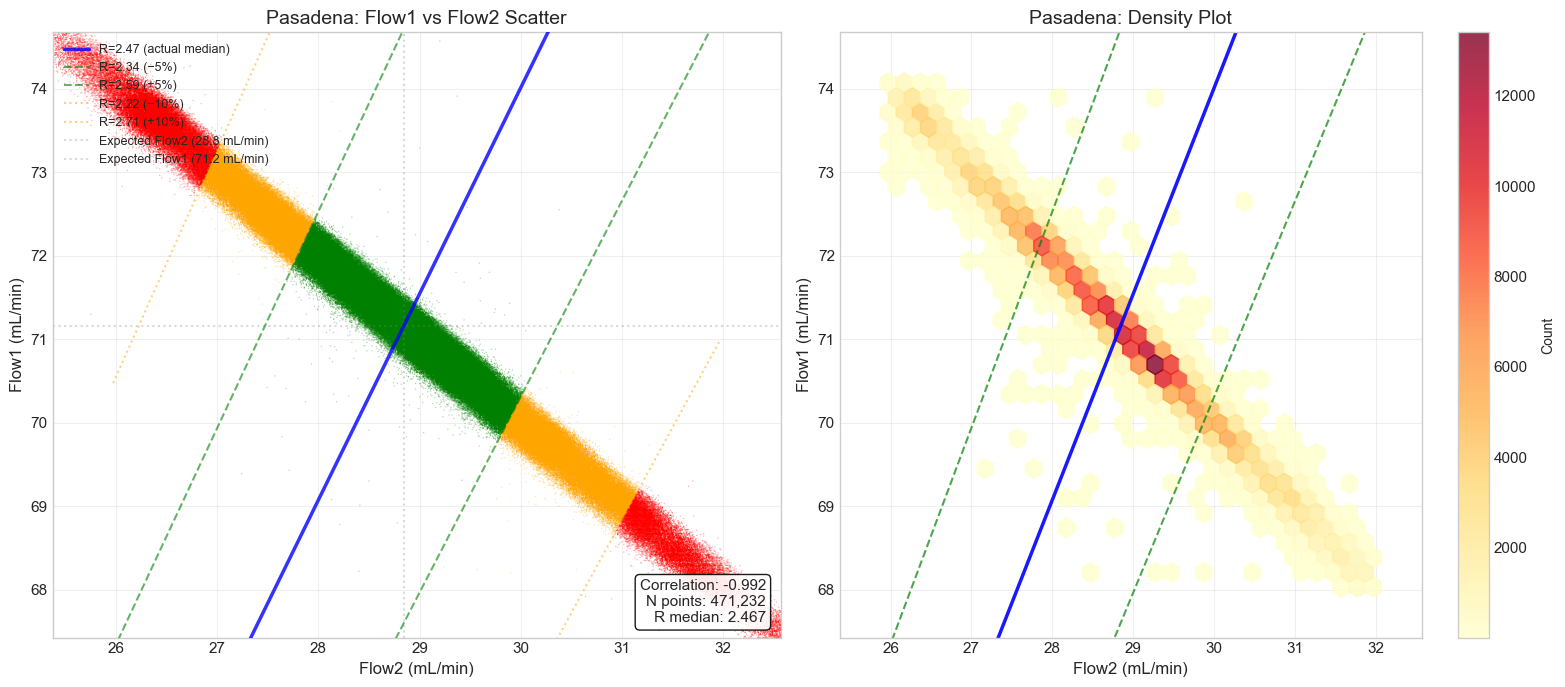

In [9]:
def plot_flow_scatter_improved(df, location):
    """
    Improved Plot 5: Flow1 vs Flow2 scatter with iso-ratio lines
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Get actual R target
    R_target = df.attrs['R_target']
    
    # Left plot: Full scatter with proper axis limits
    colors = np.where(df['flag_R_pass'], 'green', 
                     np.where(df['flag_R_warn'], 'orange', 'red'))
    
    scatter1 = ax1.scatter(df['Flow2'], df['Flow1'], 
                          c=colors, alpha=0.3, s=1, edgecolors='none')
    
    # Set axis limits based on actual data range
    flow1_min, flow1_max = df['Flow1'].quantile([0.01, 0.99])
    flow2_min, flow2_max = df['Flow2'].quantile([0.01, 0.99])
    
    # Add some padding
    padding = 0.1
    flow1_range = flow1_max - flow1_min
    flow2_range = flow2_max - flow2_min
    
    ax1.set_xlim(flow2_min - padding * flow2_range, flow2_max + padding * flow2_range)
    ax1.set_ylim(flow1_min - padding * flow1_range, flow1_max + padding * flow1_range)
    
    # Add iso-ratio lines for actual target
    flow2_line = np.linspace(flow2_min, flow2_max, 100)
    
    # Target ratio line
    ax1.plot(flow2_line, R_target * flow2_line, 'b-', linewidth=2.5, 
            label=f'R={R_target:.2f} (actual median)', alpha=0.8, zorder=5)
    
    # ±5% boundaries
    ax1.plot(flow2_line, R_target * 0.95 * flow2_line, 'g--', linewidth=1.5, 
            label=f'R={R_target*0.95:.2f} (−5%)', alpha=0.6, zorder=4)
    ax1.plot(flow2_line, R_target * 1.05 * flow2_line, 'g--', linewidth=1.5, 
            label=f'R={R_target*1.05:.2f} (+5%)', alpha=0.6, zorder=4)
    
    # ±10% boundaries
    ax1.plot(flow2_line, R_target * 0.90 * flow2_line, 'orange', linestyle=':', 
            linewidth=1.5, label=f'R={R_target*0.90:.2f} (−10%)', alpha=0.5, zorder=3)
    ax1.plot(flow2_line, R_target * 1.10 * flow2_line, 'orange', linestyle=':', 
            linewidth=1.5, label=f'R={R_target*1.10:.2f} (+10%)', alpha=0.5, zorder=3)
    
    # Expected values for 100 mL/min total flow
    if R_target > 2.5:  # If target is close to 3.0
        ax1.axvline(x=25, color='gray', linestyle=':', alpha=0.3, label='Expected Flow2 (25 mL/min)')
        ax1.axhline(y=75, color='gray', linestyle=':', alpha=0.3, label='Expected Flow1 (75 mL/min)')
    else:  # Adjust for actual ratio
        expected_flow2 = 100 / (1 + R_target)
        expected_flow1 = 100 * R_target / (1 + R_target)
        ax1.axvline(x=expected_flow2, color='gray', linestyle=':', alpha=0.3, 
                   label=f'Expected Flow2 ({expected_flow2:.1f} mL/min)')
        ax1.axhline(y=expected_flow1, color='gray', linestyle=':', alpha=0.3, 
                   label=f'Expected Flow1 ({expected_flow1:.1f} mL/min)')
    
    ax1.set_xlabel('Flow2 (mL/min)', fontsize=12)
    ax1.set_ylabel('Flow1 (mL/min)', fontsize=12)
    ax1.set_title(f'{location}: Flow1 vs Flow2 Scatter', fontsize=14)
    ax1.grid(True, alpha=0.3, zorder=0)
    ax1.legend(loc='upper left', fontsize=9, framealpha=0.9)
    
    # Add statistics
    correlation = df[['Flow1', 'Flow2']].corr().iloc[0, 1]
    stats_text = f"Correlation: {correlation:.3f}\n"
    stats_text += f"N points: {len(df):,}\n"
    stats_text += f"R median: {R_target:.3f}"
    
    ax1.text(0.98, 0.02, stats_text, transform=ax1.transAxes,
            fontsize=11, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # Right plot: 2D histogram/density plot
    from scipy.stats import gaussian_kde
    
    # Remove outliers for density calculation
    mask = (df['Flow1'] >= flow1_min) & (df['Flow1'] <= flow1_max) & \
           (df['Flow2'] >= flow2_min) & (df['Flow2'] <= flow2_max)
    flow1_clean = df.loc[mask, 'Flow1'].values
    flow2_clean = df.loc[mask, 'Flow2'].values
    
    # Create hexbin plot for density
    hexbin = ax2.hexbin(flow2_clean, flow1_clean, gridsize=30, 
                       cmap='YlOrRd', mincnt=1, alpha=0.8)
    
    # Add the same iso-ratio lines
    ax2.plot(flow2_line, R_target * flow2_line, 'b-', linewidth=2.5, alpha=0.9)
    ax2.plot(flow2_line, R_target * 0.95 * flow2_line, 'g--', linewidth=1.5, alpha=0.7)
    ax2.plot(flow2_line, R_target * 1.05 * flow2_line, 'g--', linewidth=1.5, alpha=0.7)
    
    ax2.set_xlim(flow2_min - padding * flow2_range, flow2_max + padding * flow2_range)
    ax2.set_ylim(flow1_min - padding * flow1_range, flow1_max + padding * flow1_range)
    
    ax2.set_xlabel('Flow2 (mL/min)', fontsize=12)
    ax2.set_ylabel('Flow1 (mL/min)', fontsize=12)
    ax2.set_title(f'{location}: Density Plot', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # Add colorbar
    cb = plt.colorbar(hexbin, ax=ax2)
    cb.set_label('Count', fontsize=10)
    
    plt.tight_layout()
    return fig

# Create improved scatter plots
fig9 = plot_flow_scatter_improved(jacros_processed, 'Jacros')
plt.show()

fig10 = plot_flow_scatter_improved(pasadena_processed, 'Pasadena')
plt.show()

## 6. Combined Analysis Dashboard

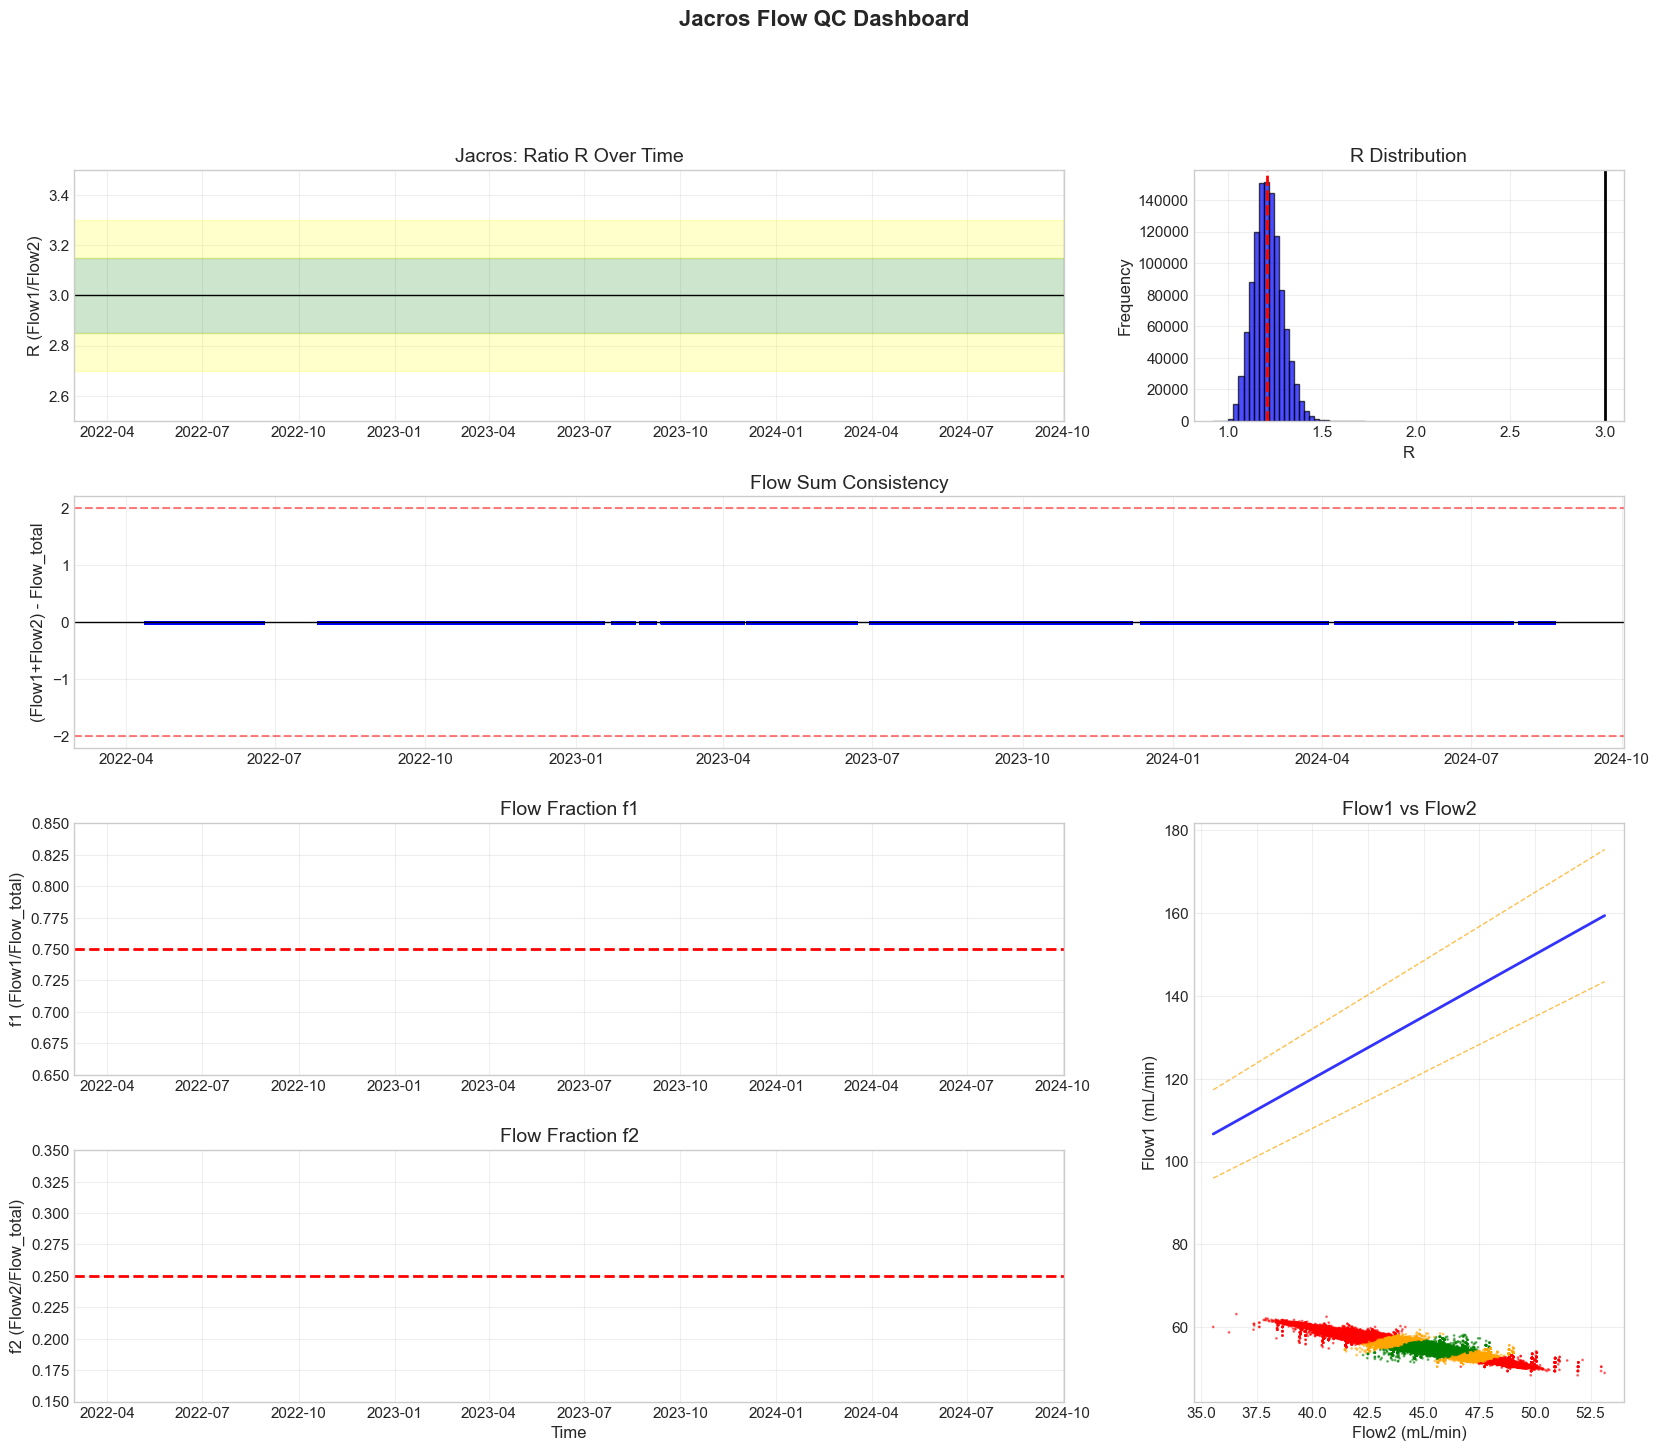

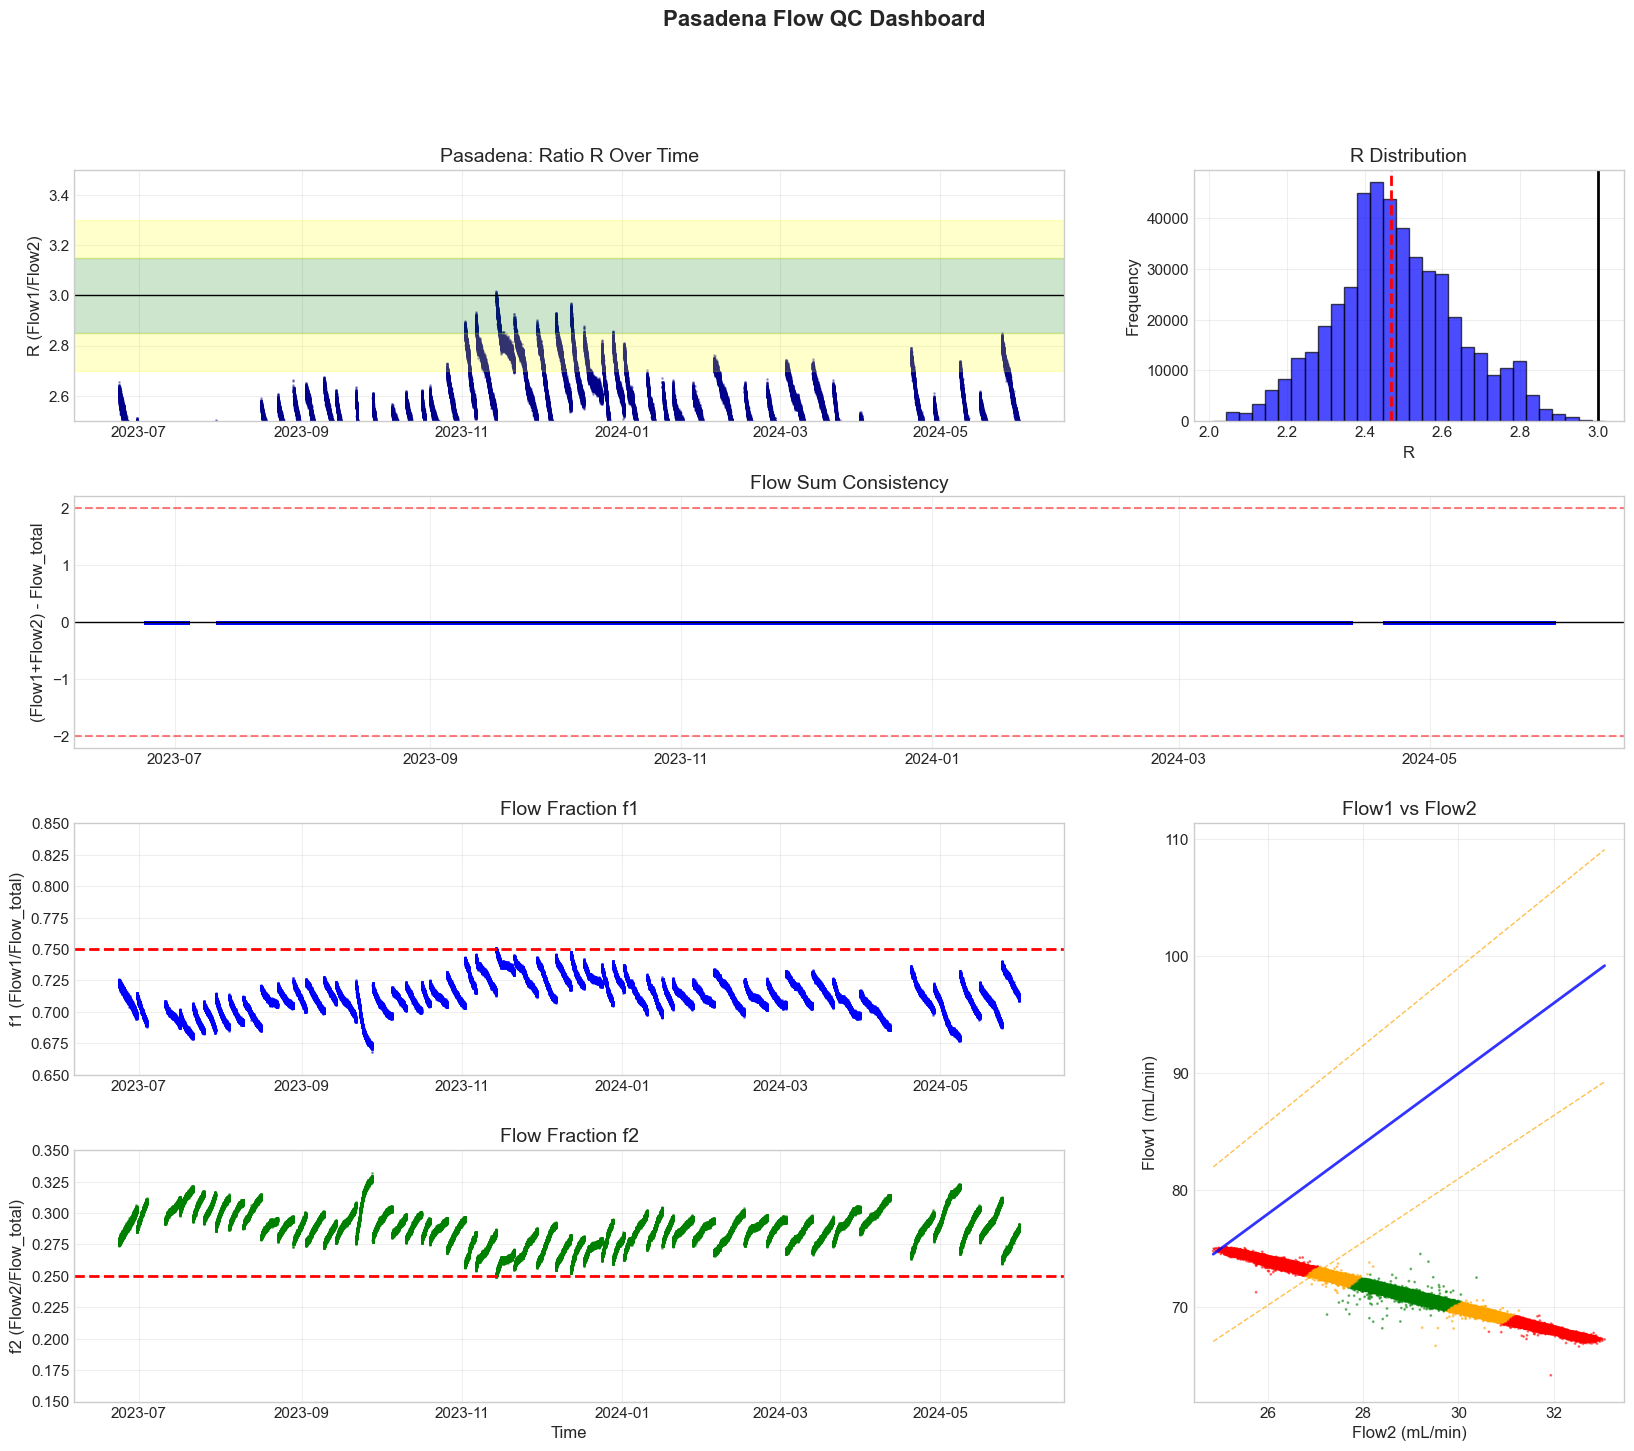

In [10]:
def create_dashboard(df, location):
    """
    Create a comprehensive dashboard with all key plots
    """
    fig = plt.figure(figsize=(20, 16))
    
    # Define grid
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    
    # 1. R time series (top, spanning 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.scatter(df['Timestamp'], df['R'], alpha=0.3, s=1, c='darkblue')
    ax1.axhspan(2.85, 3.15, alpha=0.2, color='green')
    ax1.axhspan(2.70, 2.85, alpha=0.2, color='yellow')
    ax1.axhspan(3.15, 3.30, alpha=0.2, color='yellow')
    ax1.axhline(y=3.0, color='black', linestyle='-', linewidth=1)
    ax1.axhline(y=df['R'].median(), color='red', linestyle='--', linewidth=2)
    ax1.set_ylabel('R (Flow1/Flow2)')
    ax1.set_title(f'{location}: Ratio R Over Time')
    ax1.set_ylim(2.5, 3.5)
    ax1.grid(True, alpha=0.3)
    
    # 2. R distribution
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.hist(df['R'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax2.axvline(x=3.0, color='black', linestyle='-', linewidth=2)
    ax2.axvline(x=df['R'].median(), color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('R')
    ax2.set_ylabel('Frequency')
    ax2.set_title('R Distribution')
    ax2.grid(True, alpha=0.3)
    
    # 3. Flow sum difference
    ax3 = fig.add_subplot(gs[1, :])
    ax3.scatter(df['Timestamp'], df['Flow_sum_diff'], alpha=0.5, s=1, c='blue')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax3.axhline(y=2, color='red', linestyle='--', alpha=0.5)
    ax3.axhline(y=-2, color='red', linestyle='--', alpha=0.5)
    ax3.set_ylabel('(Flow1+Flow2) - Flow_total')
    ax3.set_title('Flow Sum Consistency')
    ax3.grid(True, alpha=0.3)
    
    # 4. f1 time series
    ax4 = fig.add_subplot(gs[2, :2])
    ax4.scatter(df['Timestamp'], df['f1'], alpha=0.5, s=1, c='blue')
    ax4.axhline(y=0.75, color='red', linestyle='--', linewidth=2)
    ax4.set_ylabel('f1 (Flow1/Flow_total)')
    ax4.set_ylim(0.65, 0.85)
    ax4.set_title('Flow Fraction f1')
    ax4.grid(True, alpha=0.3)
    
    # 5. Flow1 vs Flow2 scatter
    ax5 = fig.add_subplot(gs[2:, 2])
    colors = np.where(df['flag_R_pass'], 'green', 
                     np.where(df['flag_R_warn'], 'orange', 'red'))
    ax5.scatter(df['Flow2'], df['Flow1'], c=colors, alpha=0.5, s=1)
    flow2_range = np.linspace(df['Flow2'].min(), df['Flow2'].max(), 100)
    ax5.plot(flow2_range, 3.0 * flow2_range, 'b-', linewidth=2, alpha=0.8)
    ax5.plot(flow2_range, 2.7 * flow2_range, 'orange', linestyle='--', linewidth=1, alpha=0.7)
    ax5.plot(flow2_range, 3.3 * flow2_range, 'orange', linestyle='--', linewidth=1, alpha=0.7)
    ax5.set_xlabel('Flow2 (mL/min)')
    ax5.set_ylabel('Flow1 (mL/min)')
    ax5.set_title('Flow1 vs Flow2')
    ax5.grid(True, alpha=0.3)
    
    # 6. f2 time series
    ax6 = fig.add_subplot(gs[3, :2])
    ax6.scatter(df['Timestamp'], df['f2'], alpha=0.5, s=1, c='green')
    ax6.axhline(y=0.25, color='red', linestyle='--', linewidth=2)
    ax6.set_xlabel('Time')
    ax6.set_ylabel('f2 (Flow2/Flow_total)')
    ax6.set_ylim(0.15, 0.35)
    ax6.set_title('Flow Fraction f2')
    ax6.grid(True, alpha=0.3)
    
    # Add overall title
    fig.suptitle(f'{location} Flow QC Dashboard', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    return fig

# Create dashboards
fig11 = create_dashboard(jacros_processed, 'Jacros')
plt.show()

fig12 = create_dashboard(pasadena_processed, 'Pasadena')
plt.show()

## 7. Export QC Results

In [11]:
# Combine processed data for export
combined_df = pd.concat([jacros_processed, pasadena_processed], ignore_index=True)

# Select key columns for export
export_columns = ['Location', 'Timestamp', 'Flow_setpoint', 'Flow_total', 
                 'Flow1', 'Flow2', 'R', 'f1', 'f2', 'S', 'T',
                 'flag_R_pass', 'flag_R_warn', 'flag_R_fail', 
                 'flag_S', 'flag_T', 'QC_pass']

export_df = combined_df[export_columns]

# Save to CSV
output_file = '/mnt/user-data/outputs/flow_qc_analysis_results.csv'
export_df.to_csv(output_file, index=False)

print(f"\n✅ QC results exported to: {output_file}")
print(f"Total records: {len(export_df):,}")
print(f"Jacros records: {len(export_df[export_df['Location']=='Jacros']):,}")
print(f"Pasadena records: {len(export_df[export_df['Location']=='Pasadena']):,}")
print(f"\nOverall QC Pass Rate: {export_df['QC_pass'].mean()*100:.1f}%")

OSError: Cannot save file into a non-existent directory: '/mnt/user-data/outputs'

## 8. Generate Summary Report

In [ ]:
def generate_summary_report(jacros_df, pasadena_df):
    """
    Generate a text summary report of the QC analysis
    """
    report = []
    report.append("="*70)
    report.append("FLOW DATA QUALITY CONTROL SUMMARY REPORT")
    report.append("="*70)
    report.append(f"\nReport Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    for df, location in [(jacros_df, 'Jacros'), (pasadena_df, 'Pasadena')]:
        report.append(f"\n{'='*35}")
        report.append(f"{location.upper()} SITE")
        report.append(f"{'='*35}")
        
        # Data overview
        report.append(f"\nData Overview:")
        report.append(f"  - Total records: {len(df):,}")
        report.append(f"  - Date range: {df['Timestamp'].min().date()} to {df['Timestamp'].max().date()}")
        report.append(f"  - Duration: {(df['Timestamp'].max() - df['Timestamp'].min()).days} days")
        
        # Key metrics
        report.append(f"\nKey Metrics (Target Values):")
        report.append(f"  R (3.0):   Median={df['R'].median():.3f}, Mean={df['R'].mean():.3f}, Std={df['R'].std():.3f}")
        report.append(f"  f1 (0.75): Median={df['f1'].median():.3f}, Mean={df['f1'].mean():.3f}")
        report.append(f"  f2 (0.25): Median={df['f2'].median():.3f}, Mean={df['f2'].mean():.3f}")
        report.append(f"  S (1.00):  Median={df['S'].median():.3f}, Mean={df['S'].mean():.3f}")
        report.append(f"  T (1.00):  Median={df['T'].median():.3f}, Mean={df['T'].mean():.3f}")
        
        # QC Results
        report.append(f"\nQuality Control Results:")
        report.append(f"  Ratio R QC:")
        report.append(f"    - Pass (±5%):  {df['flag_R_pass'].sum():,} ({df['flag_R_pass'].mean()*100:.1f}%)")
        report.append(f"    - Warn (±10%): {df['flag_R_warn'].sum():,} ({df['flag_R_warn'].mean()*100:.1f}%)")
        report.append(f"    - Fail (>10%): {df['flag_R_fail'].sum():,} ({df['flag_R_fail'].mean()*100:.1f}%)")
        report.append(f"  Sum Check S:     {df['flag_S'].sum():,} pass ({df['flag_S'].mean()*100:.1f}%)")
        report.append(f"  Setpoint Check T: {df['flag_T'].sum():,} pass ({df['flag_T'].mean()*100:.1f}%)")
        report.append(f"  Overall QC Pass:  {df['QC_pass'].sum():,} ({df['QC_pass'].mean()*100:.1f}%)")
        
        # Identify periods of concern
        failures = df[~df['QC_pass']]
        if len(failures) > 0:
            report.append(f"\n  Periods with Most Failures:")
            failure_dates = failures.groupby(failures['Timestamp'].dt.date).size()
            top_failure_dates = failure_dates.nlargest(3)
            for date, count in top_failure_dates.items():
                report.append(f"    - {date}: {count} failures")
    
    report.append(f"\n{'='*70}")
    report.append("END OF REPORT")
    report.append(f"{'='*70}")
    
    return "\n".join(report)

# Generate and display report
report_text = generate_summary_report(jacros_processed, pasadena_processed)
print(report_text)

# Save report to file
report_file = '/mnt/user-data/outputs/flow_qc_summary_report.txt'
with open(report_file, 'w') as f:
    f.write(report_text)
    
print(f"\n✅ Summary report saved to: {report_file}")

## 9. Conclusions and Recommendations

Based on the QC analysis performed:

### Key Findings:
1. **Ratio Performance**: Track whether the flow split ratio R stays within acceptable bounds
2. **Consistency Checks**: Monitor the sum (S) and setpoint tracking (T) metrics
3. **Temporal Patterns**: Identify any time-dependent drift or systematic issues

### Recommendations:
1. **Tighten QC Bands**: After initial analysis, consider tightening the QC bands if performance is consistently good
2. **Regular Calibration**: Schedule calibrations based on drift patterns observed
3. **Investigate Failures**: Focus maintenance efforts on periods with high failure rates
4. **Monitor Trends**: Set up alerts for systematic drift in key metrics

### Next Steps:
- Review flagged data points for patterns
- Correlate failures with environmental conditions if available
- Consider implementing automated QC monitoring
- Update QC thresholds based on operational requirements